# Eyes Open/Close Image Classification

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
#import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


### Read Data

In [2]:
# Generate data paths with labels
data_dir = 'data/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

,filepaths,labels
0,data/train/open eyes/s0014_07870_0_0_1_1_1_02.png,open eyes
1,data/train/open eyes/s0032_01991_0_1_1_2_1_02.png,open eyes
2,data/train/open eyes/s0027_00445_0_1_1_2_1_01.png,open eyes
3,data/train/open eyes/s0032_00630_0_1_1_2_1_02.png,open eyes
4,data/train/open eyes/s0036_04378_1_0_1_0_1_01.png,open eyes
...,...,...
81670,data/train/close eyes/s0017_00671_1_0_0_0_1_01...,close eyes
81671,data/train/close eyes/s0037_05742_1_1_0_0_0_01...,close eyes
81672,data/train/close eyes/s0016_00737_1_0_0_0_1_01...,close eyes
81673,data/train/close eyes/s0001_00229_0_0_0_0_0_01...,close eyes


In [4]:
train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 23)

In [7]:
# Generate data paths with labels
data_dir = 'data/test'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

### Create Image Data Generator

In [20]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 65340 validated image filenames belonging to 2 classes.
Found 16335 validated image filenames belonging to 2 classes.
Found 3223 validated image filenames belonging to 2 classes.


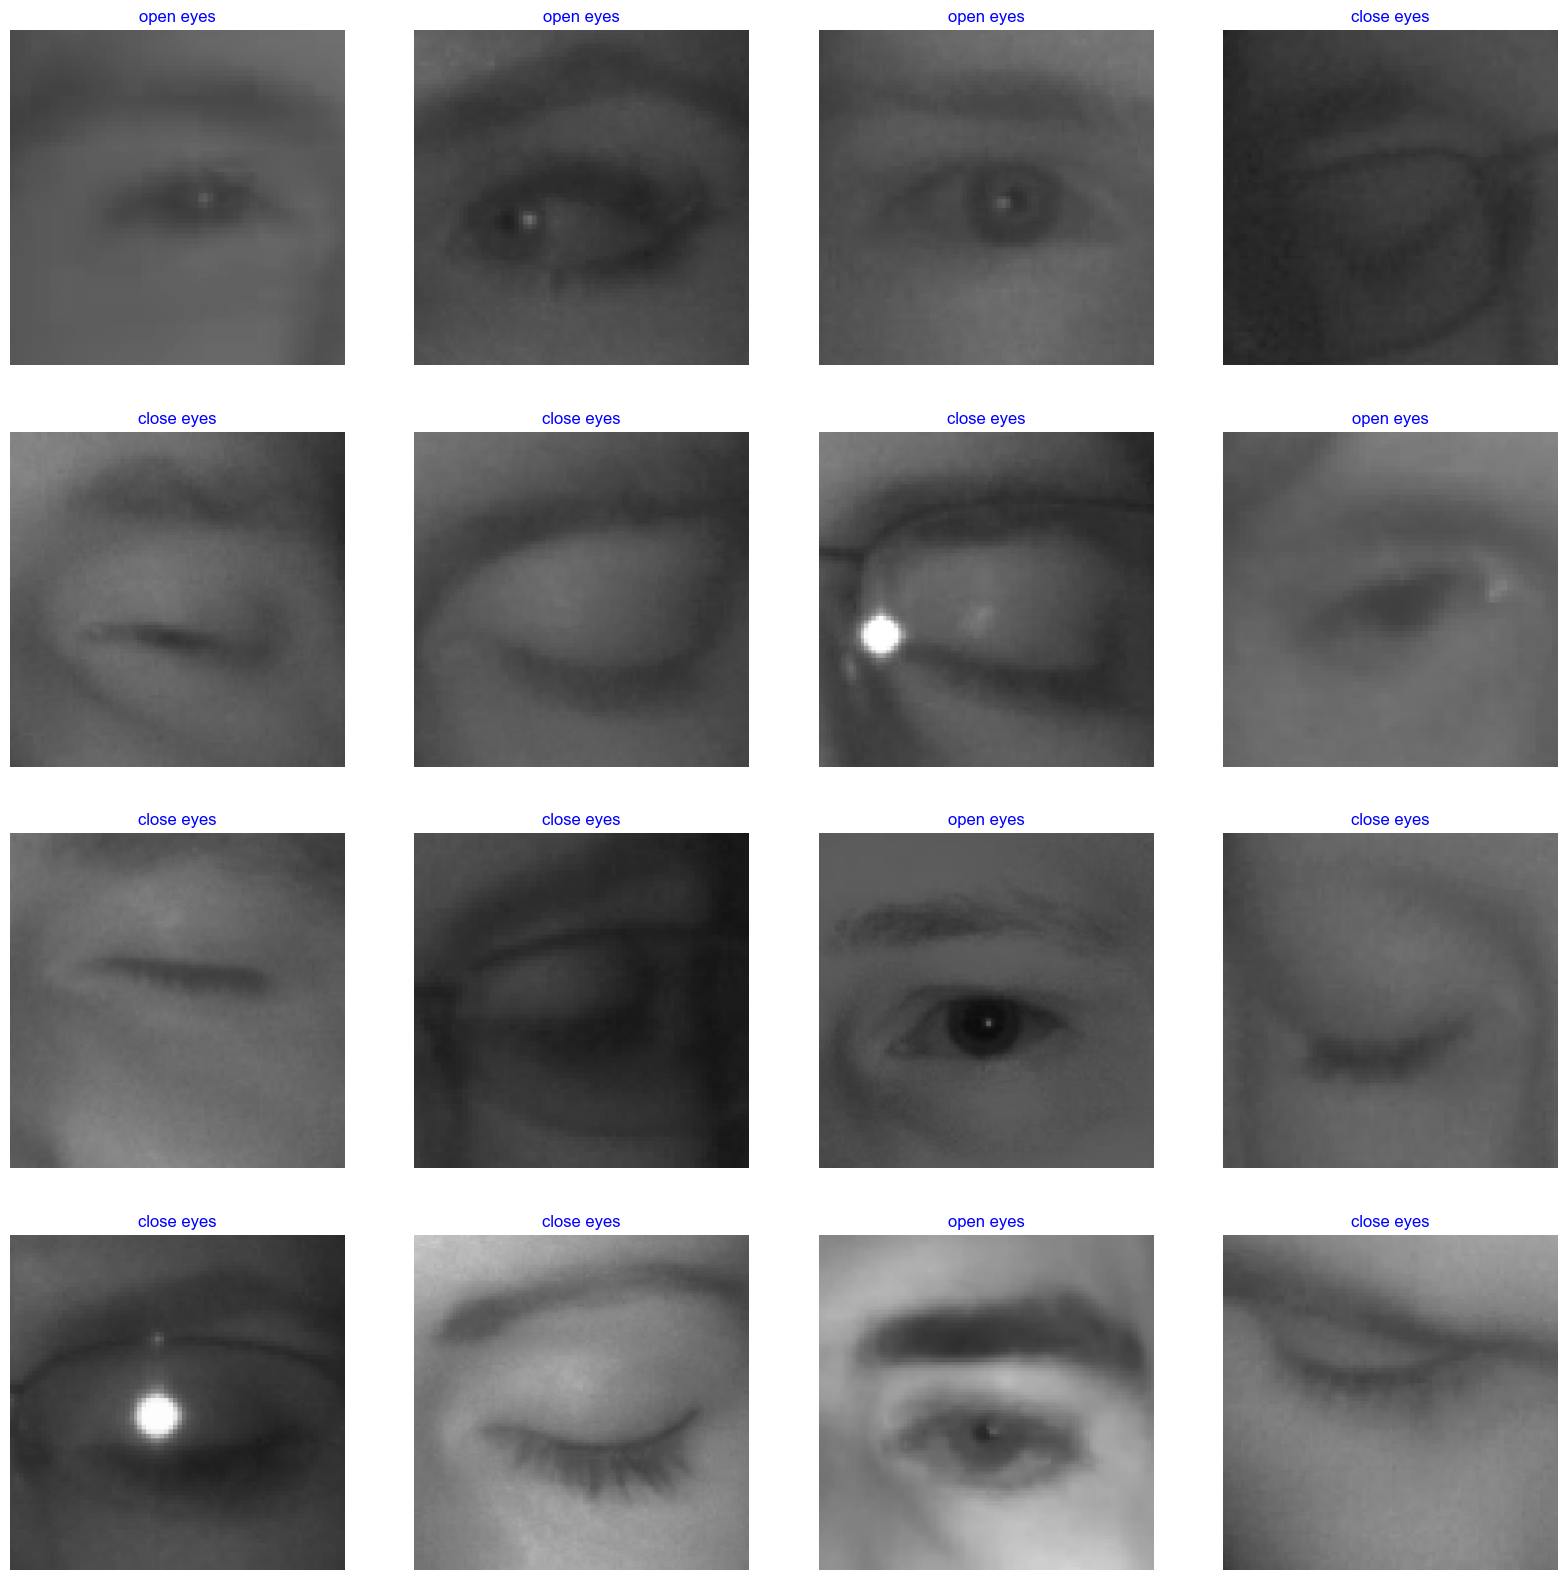

In [21]:
# Show sample from train data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

### Model Creation

In [24]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(tf.keras.optimizers.legacy.Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4383141 (16.72 MB)
Trainable params: 433

### Train model

In [25]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
4084/4084 [==============================] - 2949s 721ms/step - loss: 0.8138 - accuracy: 0.9773 - val_loss: 0.0998 - val_accuracy: 0.9901
Epoch 2/10
4084/4084 [==============================] - 10367s 3s/step - loss: 0.1000 - accuracy: 0.9887 - val_loss: 0.0765 - val_accuracy: 0.9914
Epoch 3/10
4084/4084 [==============================] - 11884s 3s/step - loss: 0.0808 - accuracy: 0.9907 - val_loss: 0.0676 - val_accuracy: 0.9903
Epoch 4/10
4084/4084 [==============================] - 2309s 565ms/step - loss: 0.0698 - accuracy: 0.9923 - val_loss: 0.0574 - val_accuracy: 0.9925
Epoch 5/10
4084/4084 [==============================] - 6274s 2s/step - loss: 0.0619 - accuracy: 0.9936 - val_loss: 0.0583 - val_accuracy: 0.9911
Epoch 6/10
4084/4084 [==============================] - 6219s 2s/step - loss: 0.0552 - accuracy: 0.9945 - val_loss: 0.0591 - val_accuracy: 0.9910
Epoch 7/10
4084/4084 [==============================] - 12647s 3s/step - loss: 0.0487 - accuracy: 0.9957 - val_loss:

### Display model performance

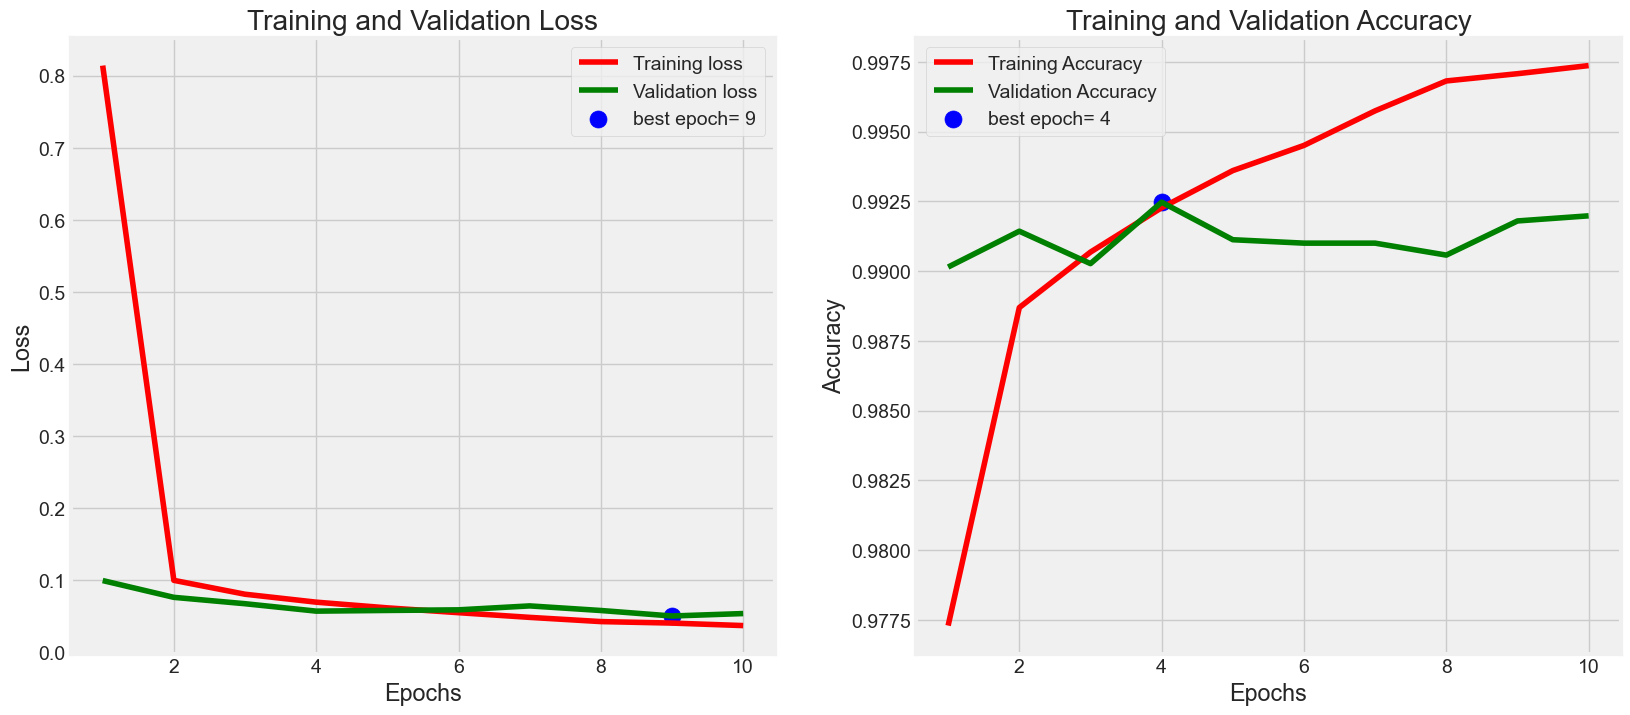

In [26]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Evaluate model

In [27]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

293/293 [==============================] - 27s 92ms/step - loss: 0.2440 - accuracy: 0.9445
Train Loss:  0.026102516800165176
Train Accuracy:  0.9985068440437317
--------------------
Validation Loss:  0.04426911473274231
Validation Accuracy:  0.9933874011039734
--------------------
Test Loss:  0.24402648210525513
Test Accuracy:  0.9444617033004761


In [28]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

### Confusion Matrix and Classification Report

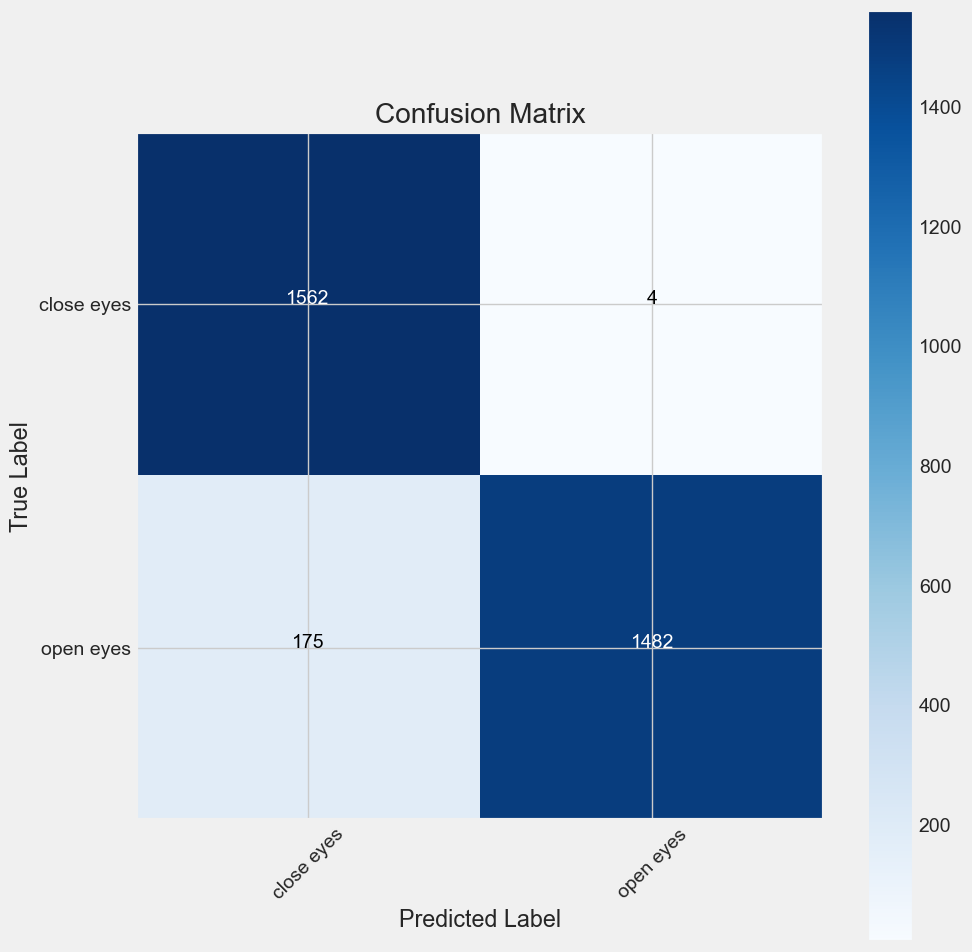

In [29]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [30]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

  close eyes       0.90      1.00      0.95      1566
   open eyes       1.00      0.89      0.94      1657

    accuracy                           0.94      3223
   macro avg       0.95      0.95      0.94      3223
weighted avg       0.95      0.94      0.94      3223



### Save model

In [31]:
model_name = model.input_names[0][:-6]
subject = 'EyeDetection'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-EyeDetection-94.45.h5
weights were saved as efficientnetb0-EyeDetection-weights.h5


In [32]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as EyeDetection-class_dict.csv


***

# External Dataset Testing

### Load in trained model

In [56]:
from tensorflow.keras.models import load_model

# Load the saved model
model_path = 'efficientnetb0-EyeDetection-94.45.h5'
model = load_model(model_path)

model.load_weights('efficientnetb0-EyeDetection-weights.h5')

## DrivFace Dataset

### Load in dataset

In [51]:
# Load in DrivFace images for testing
data_dir = 'data/DrivFace/DrivImages'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [47]:
# crobed image size
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 605 validated image filenames belonging to 2 classes.


### Test new dataset

In [48]:
# Calculate the steps (number of batches needed to go through the entire test set)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = (ts_length + test_batch_size - 1) // test_batch_size  # This rounds up to cover all samples

# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 4s 369ms/step - loss: 2.8024 - accuracy: 0.1306
Test Loss:  2.8023948669433594
Test Accuracy:  0.13057851791381836


11/11 [==============================] - 4s 347ms/step


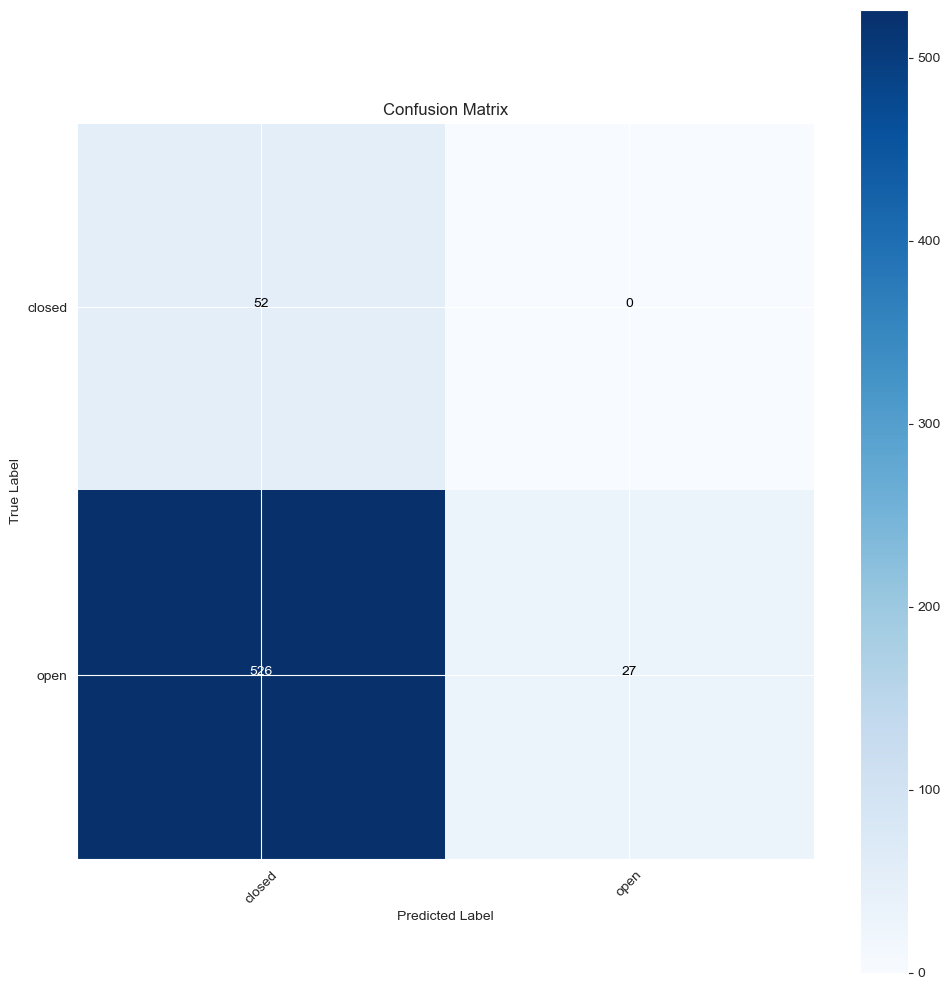

              precision    recall  f1-score   support

      closed       0.09      1.00      0.17        52
        open       1.00      0.05      0.09       553

    accuracy                           0.13       605
   macro avg       0.54      0.52      0.13       605
weighted avg       0.92      0.13      0.10       605



In [49]:
# Predict the entire dataset
preds = model.predict(test_gen, verbose=1)
# Get the index of the maximum score in the prediction (class index)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

print(classification_report(test_gen.classes, y_pred, target_names= classes))

## Closed Eyes In The Wild Dataset

### Load in dataset

In [52]:
# Load in DrivFace images for testing
data_dir = 'data/CEW'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [53]:
# crobed image size
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 2423 validated image filenames belonging to 2 classes.


### Test new dataset

In [54]:
# Calculate the steps (number of batches needed to go through the entire test set)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = (ts_length + test_batch_size - 1) // test_batch_size  # This rounds up to cover all samples

# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

97/97 [==============================] - 15s 154ms/step - loss: 41.4840 - accuracy: 0.4825
Test Loss:  41.48398971557617
Test Accuracy:  0.48245975375175476


97/97 [==============================] - 15s 155ms/step


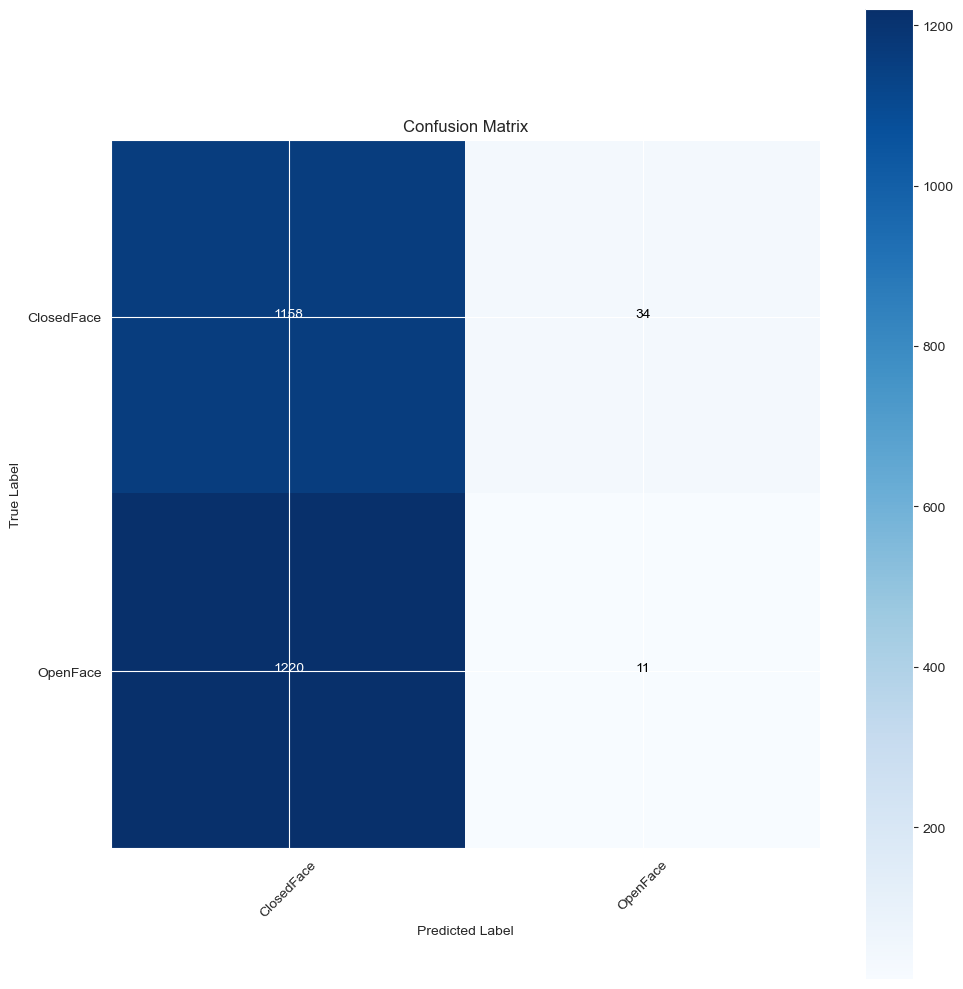

              precision    recall  f1-score   support

  ClosedFace       0.49      0.97      0.65      1192
    OpenFace       0.24      0.01      0.02      1231

    accuracy                           0.48      2423
   macro avg       0.37      0.49      0.33      2423
weighted avg       0.36      0.48      0.33      2423



In [55]:
# Predict the entire dataset
preds = model.predict(test_gen, verbose=1)
# Get the index of the maximum score in the prediction (class index)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

print(classification_report(test_gen.classes, y_pred, target_names= classes))

## Closed Eyes In The Wild (Eye Patches) Dataset

### Load in dataset

In [58]:
# Load in DrivFace images for testing
data_dir = 'data/CEW_eyepatches'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [59]:
# crobed image size
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4846 validated image filenames belonging to 2 classes.


### Test new dataset

In [60]:
# Calculate the steps (number of batches needed to go through the entire test set)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = (ts_length + test_batch_size - 1) // test_batch_size  # This rounds up to cover all samples

# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2423/2423 [==============================] - 63s 26ms/step - loss: 0.3228 - accuracy: 0.8824
Test Loss:  0.3227684795856476
Test Accuracy:  0.8823772072792053


2423/2423 [==============================] - 69s 28ms/step


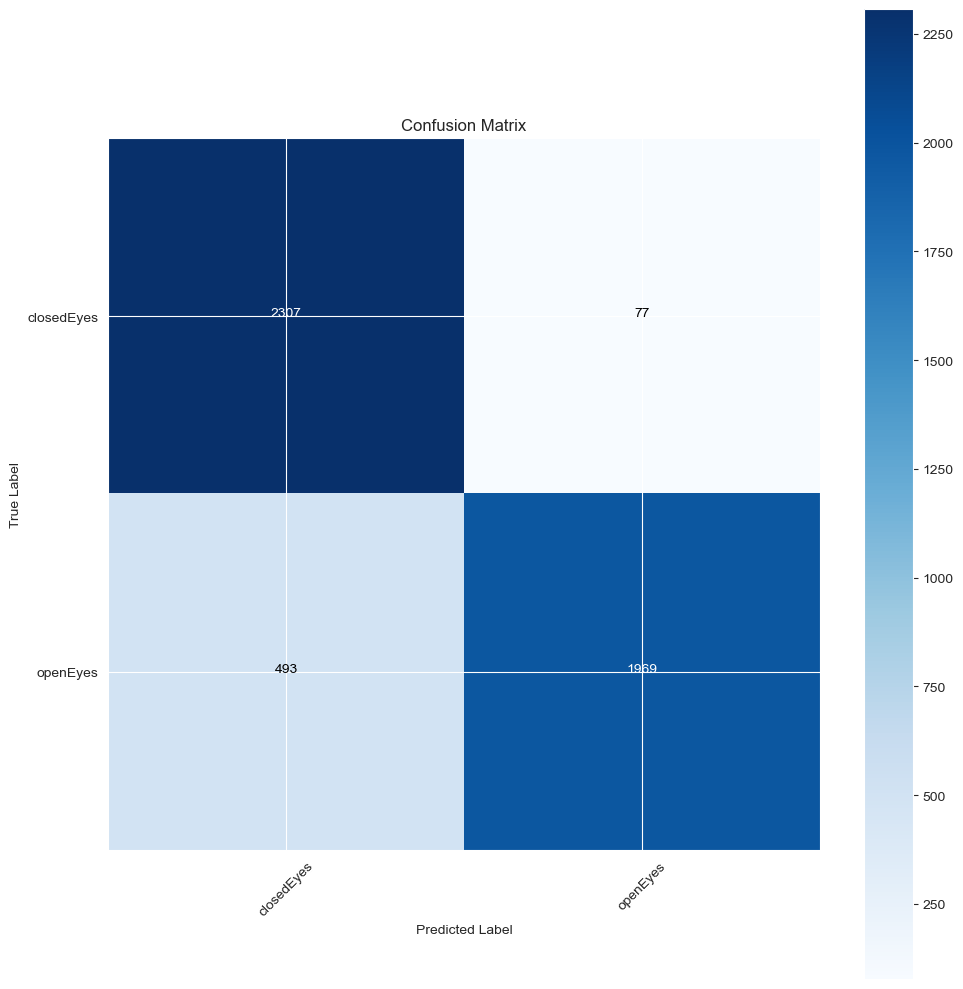

              precision    recall  f1-score   support

  closedEyes       0.82      0.97      0.89      2384
    openEyes       0.96      0.80      0.87      2462

    accuracy                           0.88      4846
   macro avg       0.89      0.88      0.88      4846
weighted avg       0.89      0.88      0.88      4846



In [61]:
# Predict the entire dataset
preds = model.predict(test_gen, verbose=1)
# Get the index of the maximum score in the prediction (class index)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

print(classification_report(test_gen.classes, y_pred, target_names= classes))